In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
# os.chdir('./drive/MyDrive/project')
print(os.getcwd())  # Print the current working directory
print(os.listdir()) # Print the contents of the current working directory

/content
['.config', 'drive', 'sample_data']


In [ ]:
'''
https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
'''

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion Matrix',
                          cmap=None,
                          normalize=False,
                          fontsize=12):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('{}\nAccuracy: {:0.4f}; Misclass: {:0.4f}'.format(title,accuracy, misclass))
    plt.colorbar(fraction=0.046, pad=0.04)

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize=fontsize)
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize=fontsize)


    plt.tight_layout()
    plt.ylabel('True label', fontsize=fontsize)
    plt.xlabel('Predicted label', fontsize=fontsize)
    plt.show()

def prediction_evaluation(predicted_label, true_label, subject_id=1):
    # accuracy can be calculated as: 
    # predictedRight / (predictedRight + predictedWrong)
    right, wrong = 0, 0
    for predictedLabel, realLabel in zip(predicted_label, true_label):
        if predictedLabel == realLabel:
            right += 1
        else:
            wrong += 1
    acc = right / (right + wrong) 
    print("Overall Accuracy: %d%%" % (acc * 100))
    
    # True Positive (TP): real label IS subject_id and predicted label IS subject_id
    # False Positive (FP): real label is NOT subject_id while predicted label IS subject_id
    # True Negative (TN): real label is NOT subject_id and predicted label is NOT subject_id
    # False Negative (FN): real label IS subject_id and predicted label is NOT subject_id
    
    TP, FP, TN, FN = 0, 0, 0, 0
    for predictedLabel, realLabel in zip(predicted_label, true_label):
        if predictedLabel == subject_id and realLabel == subject_id:
            TP += 1
        if predictedLabel != subject_id and realLabel == subject_id:
            FN += 1
        if predictedLabel != subject_id and realLabel != subject_id:
            TN += 1
        if predictedLabel == subject_id and realLabel != subject_id:
            FP += 1
    print("Subject #%d:\n\tTP: %d, FP: %d, TN: %d, FN: %d" % (subject_id, TP, FP, TN, FN))
    
    # True Positive Rate (TPR) also known as Sensitivity or Recall
    TPR = TP / (TP + FN)
    # True Negative Rate (TNR) also known as Specificity
    TNR = TN / (TN + FP)
    # False Positive Rate (FPR)
    FPR = FP / (FP + TN)
    # False Negative Rate (FNR)
    FNR = FN / (TP + FN)

    print("\tTPR: %.2f%%, TNR: %.2f%%, FPR: %.2f%%, FNR: %.2f%%" % (TPR*100, TNR*100, FPR*100, FNR*100))

#Face Detection

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve , det_curve
from glob import glob
from google.colab.patches import cv2_imshow
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import normalize
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

In [ ]:
# Pick for face detection
# face_cascade = cv2.CascadeClassifier('lbpcascade_frontalface.xml')
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

train_path = './drive/MyDrive/encm509/project/ATT dataset'
test_path = './drive/MyDrive/encm509/project/ATT dataset'

#Custom Load Function to load datasets

In [ ]:
def load_images(root_dir, tag):
  size=128 # image size fixed to 128x128
  use_face_detection=False # dont use face detection for this data
  folders = glob(root_dir + '/*')
  # parameter for LBP feature extraction
  radius = 2 
  n_points = 10
  # bins for Histogram of LBP
  num_bins = 16
  # Arrays to return: images and corresponding labels
  images = []
  labels = []
  # For each folder in the Test/Train folder
  for folder in folders:
    label = int(os.path.basename(folder)[1:]) # "s#" = label number
    paths = glob(folder + '/*')
    # if tag == "train":
    #   paths = paths[:6] # Pick first 7 images for training
    # elif tag == "test":
    #   paths = paths[-4:] # Pick last 3 images for testing
    if tag == "train":
      paths = np.random.choice(paths, size=7, replace=False) # Randomly pick 7 images for training
    elif tag == "test":
      paths = np.random.choice(paths, size=3, replace=False) # Randomly pick 3 images for testing
    # fig, axs = plt.subplots(nrows=1, ncols=len(paths), figsize=(15, 8))
    # For each file/image in s# folder
    for i, path in enumerate(paths):
      img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) # read img as grayscale
      if use_face_detection: # Not needed for ATT dataset as its already cropped to the face
        faces = face_cascade.detectMultiScale(img, scaleFactor=1.01, minNeighbors=5)
        for (x, y, w, h) in faces:
          face_img = img[y:y+h, x:x+w] # crop the detected face
          face_img = cv2.resize(face_img, (size, size)) 
          face_img = cv2.equalizeHist(face_img) 
          face_img = cv2.GaussianBlur(face_img, (3,3), 0)
          face_img = (face_img - np.min(face_img)) / (np.max(face_img) - np.min(face_img))
          lbp = local_binary_pattern(face_img, n_points, radius)
          hist, _ = np.histogram(lbp.ravel(), bins=num_bins, range=(0, num_bins))
          # hist = normalize(hist.reshape(1, -1), norm='l2')
          images.append(hist.flatten())
          labels.append(label)
          # axs[i].imshow(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)) **FOR PLOTTING**
          # axs[i].axis('off')
      else: # if not using face detection then just apply pre-procesing to img
        # img = cv2.resize(img ,(1 , len(img)*len(img [0])))
        # img = np.float32(np.array(img)/255.0)
        img = cv2.resize(img, (size, size)) # resize to 128 x 128
        img = cv2.equalizeHist(img) # histogram equalization
        img = cv2.GaussianBlur(img, (3,3), 0) # Gaussian filter
        img = (img - np.min(img)) / (np.max(img) - np.min(img)) # min-max normalization
        lbp = local_binary_pattern(img, n_points, radius) # LBP feature extraction
        hist, _ = np.histogram(lbp.ravel(), bins=num_bins, range=(0, num_bins))
        # hist = normalize(hist.reshape(1, -1), norm='l2')
        # hist = hist.astype("float")
        # hist /= (hist.sum() + 1e-7)
        images.append(hist)
        labels.append(int(label)-1)
        # axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) **FOR PLOTTING**
        # axs[i].axis('off')
  # plt.show()
  return np.array(images), np.array(labels)

# Exploring preprocessing methodology visually

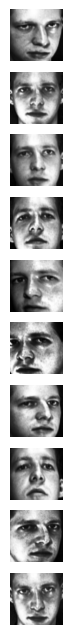

In [ ]:
face_cascade = cv2. CascadeClassifier ('haarcascade_frontalface_default.xml')
paths = glob('ATT dataset/Train/s1/*')

# fig, axs = plt.subplots(nrows=1, ncols=len(paths), figsize=(15, 8))
fig, axs = plt.subplots(nrows=len(paths), ncols=1, figsize=(15, 8))

for i, path in enumerate(paths):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    faces = face_cascade.detectMultiScale(img, scaleFactor=1.01, minNeighbors=6)
    
    for (x, y, w, h) in faces:
        face_img = img[y:y+h, x:x+w] # crop the detected face
        face_img = cv2.resize(face_img, (128, 128)) # resize to 128x128
        face_img = cv2.equalizeHist(face_img) # histogram equalization
        face_img = cv2.GaussianBlur(face_img, (3,3), 0) # Gaussian filter
        face_img = np.float32(face_img)/255.0 # normalize to 0-1
        face_img = np.reshape(face_img, (1, -1)) # reshape to 1D vector
        
        axs[i].imshow(cv2.cvtColor(face_img.reshape((128,128)), cv2.COLOR_BGR2RGB))
        axs[i].axis('off')

plt.show()


#Load data

In [ ]:
X_train, y_train = load_images(train_path, "train")
# Shuffle the indices of X_train and y_train
idx = np.random.permutation(len(X_train))
X_train_shuffled = X_train[idx]
y_train_shuffled = y_train[idx]
print(X_train.shape)
print(y_train.shape)

X_test, y_test = load_images(test_path, "test")
# Shuffle the indices of X_train and y_train
idx = np.random.permutation(len(X_test))
X_test_shuffled = X_test[idx]
y_test_shuffled = y_test[idx]
print(X_test.shape)
print(y_test.shape)



(280, 16)
(280,)
(120, 16)
(120,)


In [ ]:
print(np.unique(y_train_shuffled))
print(np.unique(y_test_shuffled))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


#Using the Support Vector Machine (SVM) classifier

In [ ]:
print("Fitting the classifier to the training set")
param_grid = {
         'C': [1e3, 0.1, 1e5, 5, 1, 10, 100],
          'gamma': [0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
clf = GridSearchCV(SVC(kernel='rbf'), param_grid)
clf = clf.fit(X_train_shuffled, y_train_shuffled)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=1000.0, gamma=1e-05)


In [ ]:
# Train SVM model with 2D array
svm = SVC(C=1000.0, gamma=1e-05, kernel='rbf', probability=True) 
svm.fit(X_train_shuffled, y_train_shuffled)

SVC(C=1000.0, gamma=1e-05, probability=True)

In [ ]:
# Calculate Training Accuracy
prob_matrix = svm.predict_proba(X_train_shuffled)
# calculate accuracy
prediction = np. argmax (prob_matrix ,1)
# print(prediction)
# print(y_train_shuffled)
result = prediction == y_train_shuffled
accuracy = (np.sum(result)/len(result))*100
print("Training Accuracy= ", accuracy)

# Calculate Testing Accuracy
# probability matrix NxM where N is number of samples and M is the number of classes
prob_matrix = svm.predict_proba(X_test_shuffled)

# calculate accuracy
prediction = np.argmax (prob_matrix ,1)
y_pred = prediction
# print(prediction)
# print(y_test_shuffled)
result = prediction == y_test_shuffled
accuracy = (np.sum(result)/len(result))*100
print("Testing Accuracy= ", accuracy)


Training Accuracy=  100.0
Testing Accuracy=  95.83333333333334


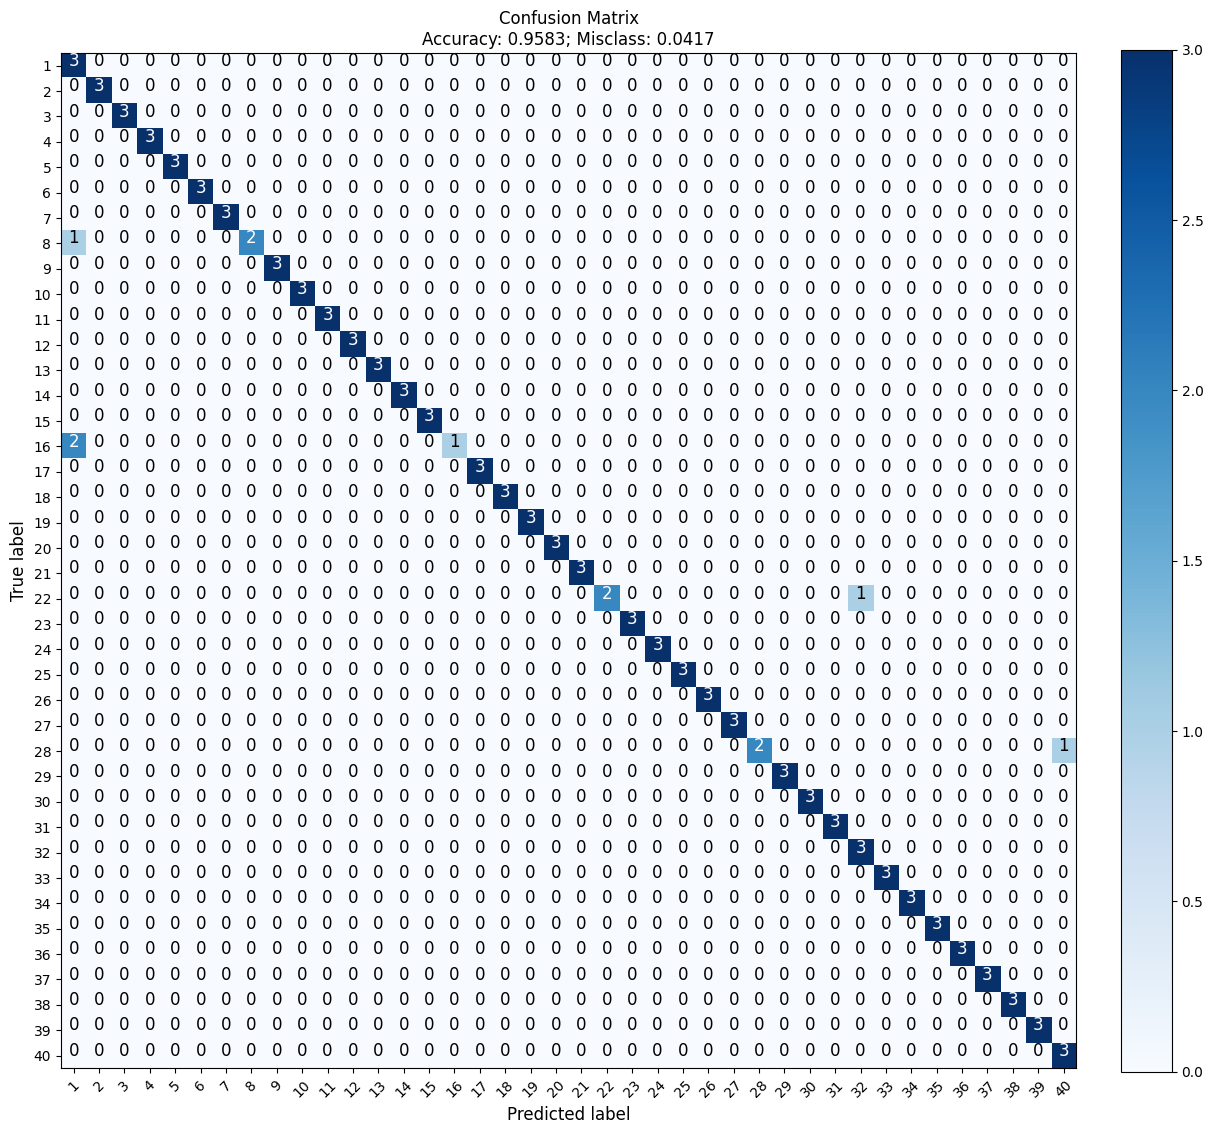

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
mat = confusion_matrix(y_test_shuffled, y_pred)

plot_confusion_matrix(cm=mat,
                      target_names = [i for i in range(1, 40+1)])


95.83333333333334


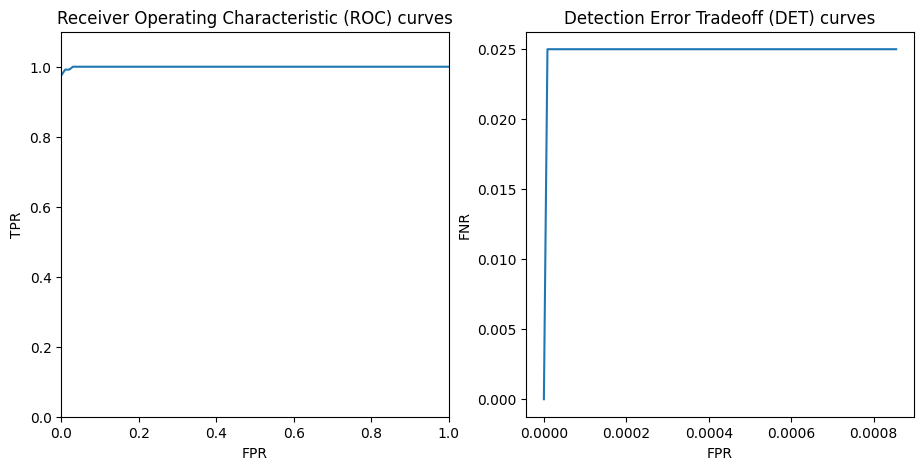

In [ ]:
# probability matrix NxM where N is number of samples and M is the number of classes
probability_matrix = svm.predict_proba(X_test_shuffled)

# calculate accuracy
prediction = np.argmax(probability_matrix,1)
result = prediction == y_test_shuffled
accuracy = (np.sum(result)/len(result))*100
print(accuracy)

# false positive rate (FPR)
# true positive rate (TPR)
# false negative rate (FNR)
# 40 subjects by 100 values
roc_fpr = np.zeros((40,100))
roc_tpr = np.zeros((40,100))
det_fpr = np.zeros((40,100))
det_fnr = np.zeros((40,100))
fig , [ax_roc , ax_det] = plt.subplots(1,2,figsize=(11,5))

# iterate through number of subjects (40)
# calculating the ROC and DET curve for each subject
for i in range (40):
# find the fpr by tpr values for ROC
  fpr,tpr, _ = roc_curve(y_test_shuffled[:]==i, probability_matrix[:,i])
  # interpolate rates so each curve contains 100 values
  roc_fpr[i] = np.linspace(min(fpr),max(fpr),100)
  roc_tpr[i] = np.interp(roc_fpr[i],fpr,tpr)
  # find the fpr by fnr values for DET
  fpr,fnr, _ = det_curve(y_test_shuffled[:]==i, probability_matrix[:,i])
  # interpolate rates so each curve contains 100 values
  det_fpr[i] = np.linspace(min(fpr),max(fpr),100)
  det_fnr[i] = np.interp(det_fpr[i],fpr,fnr)

# average each subject ’s ROC curve to get the average ROC curve of system
roc_mid_fpr = np.mean(roc_fpr,0)
roc_mid_tpr = np.mean(roc_tpr,0)
ax_roc.plot(roc_mid_fpr, roc_mid_tpr)
# average each subject ’s DET curve to get the average DET curve of system
det_mid_fpr = np.mean(det_fpr,0)
det_mid_fnr = np.mean(det_fnr,0)
ax_det.plot(det_mid_fpr, det_mid_fnr)
# ax_det.plot(roc_mid_fpr, roc_mid_tpr)
ax_roc.set_xlabel('FPR')
ax_roc.set_ylabel('TPR')
ax_roc.set_ylim([0,1.1])
ax_roc.set_xlim([0,1])
ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_xlabel('FPR')
ax_det.set_ylabel('FNR')
# ax_det.set_xlim([0,1])
# ax_det.set_ylim([0,1.1])
ax_det.set_title("Detection Error Tradeoff (DET) curves")
plt.show()

In [ ]:
accuracy = accuracy_score(y_test_shuffled, y_pred)
report = classification_report(y_test_shuffled, y_pred)
print("Classification Report: \n", report)

Classification Report: 
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      0.67      0.80         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3
          15       1.00      0.33      0.50         3
          16       1.00      1.00      1.00         3
  

## Using Predict()

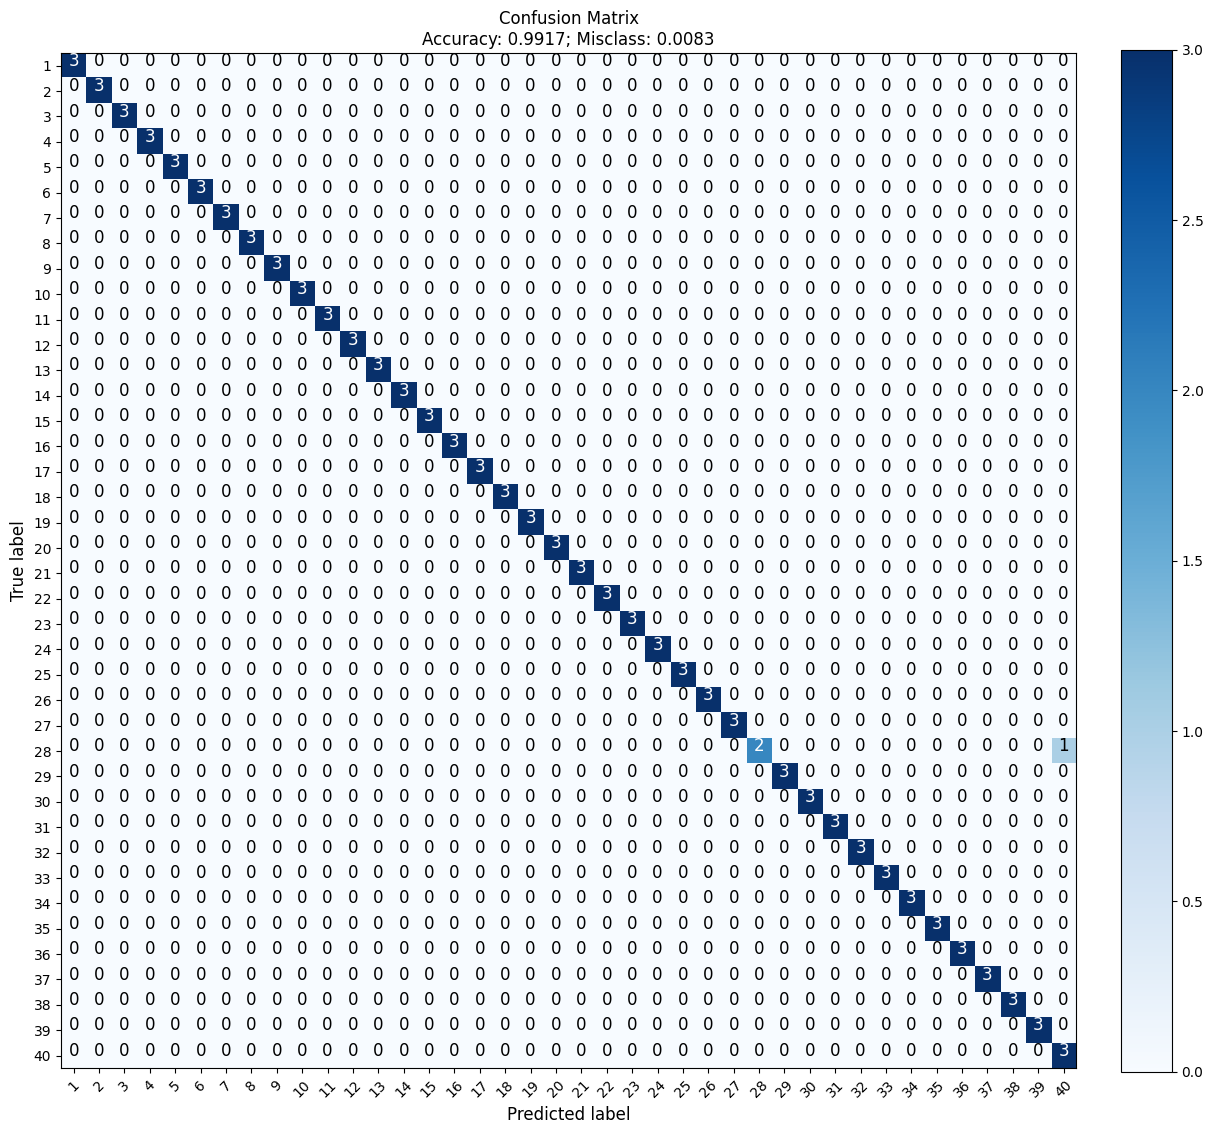

In [ ]:
# Generate the confusion matrix
y_predict = svm.predict(X_test_shuffled)
confusionMatrix = confusion_matrix(y_test_shuffled, y_predict)
plot_confusion_matrix(cm=confusionMatrix,
                      target_names = [i for i in range(1, 40+1)])

In [ ]:
prediction_evaluation(y_pred,y_test_shuffled)
prediction_evaluation(y_pred,y_test_shuffled,2)
prediction_evaluation(y_pred,y_test_shuffled,3)

Overall Accuracy: 95%
Subject #1:
	TP: 3, FP: 0, TN: 117, FN: 0
	TPR: 100.00%, TNR: 100.00%, FPR: 0.00%, FNR: 0.00%
Overall Accuracy: 95%
Subject #2:
	TP: 3, FP: 0, TN: 117, FN: 0
	TPR: 100.00%, TNR: 100.00%, FPR: 0.00%, FNR: 0.00%
Overall Accuracy: 95%
Subject #3:
	TP: 3, FP: 0, TN: 117, FN: 0
	TPR: 100.00%, TNR: 100.00%, FPR: 0.00%, FNR: 0.00%


#Using Multi-layer Perceptron (MLP) classifier

In [ ]:
random_state = 24
print("Fitting the classifier to the training set")
param_grid = {
'hidden_layer_sizes': [(50,50,50),  (256, 128, 256),  (512,512,512)],
'alpha': [0.0001, 0.01, 0.001],
'activation': ['relu','tanh']
}
clf = GridSearchCV(MLPClassifier(random_state=random_state, max_iter=100), param_grid)
clf = clf.fit(X_train_shuffled, y_train_shuffled)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

Best estimator found by grid search:
MLPClassifier(alpha=0.001, hidden_layer_sizes=(512, 512, 512), max_iter=100,
              random_state=24)


In [ ]:
mlp = MLPClassifier (hidden_layer_sizes =(512,512,512),
                     learning_rate_init = 0.001,
                     random_state=1,
                     activation='relu')
mlp.fit(X_train_shuffled, y_train_shuffled)

MLPClassifier(hidden_layer_sizes=(512, 512, 512), random_state=1)

In [ ]:
# Calculate Training Accuracy
prob_matrix = mlp.predict_proba(X_train_shuffled)
# calculate accuracy
prediction = np. argmax (prob_matrix ,1)
# print(prediction)
# print(y_train_shuffled)
result = prediction == y_train_shuffled
accuracy = (np.sum(result)/len(result))*100
print("Training Accuracy= ", accuracy)

# Calculate Testing Accuracy
# probability matrix NxM where N is number of samples and M is the number of classes
prob_matrix = mlp.predict_proba(X_test_shuffled)

# calculate accuracy
prediction = np.argmax (prob_matrix ,1)
y_pred = prediction
# print(prediction)
# print(y_test_shuffled)
result = prediction == y_test_shuffled
accuracy = (np.sum(result)/len(result))*100
print("Testing Accuracy= ", accuracy)


Training Accuracy=  100.0
Testing Accuracy=  99.16666666666667


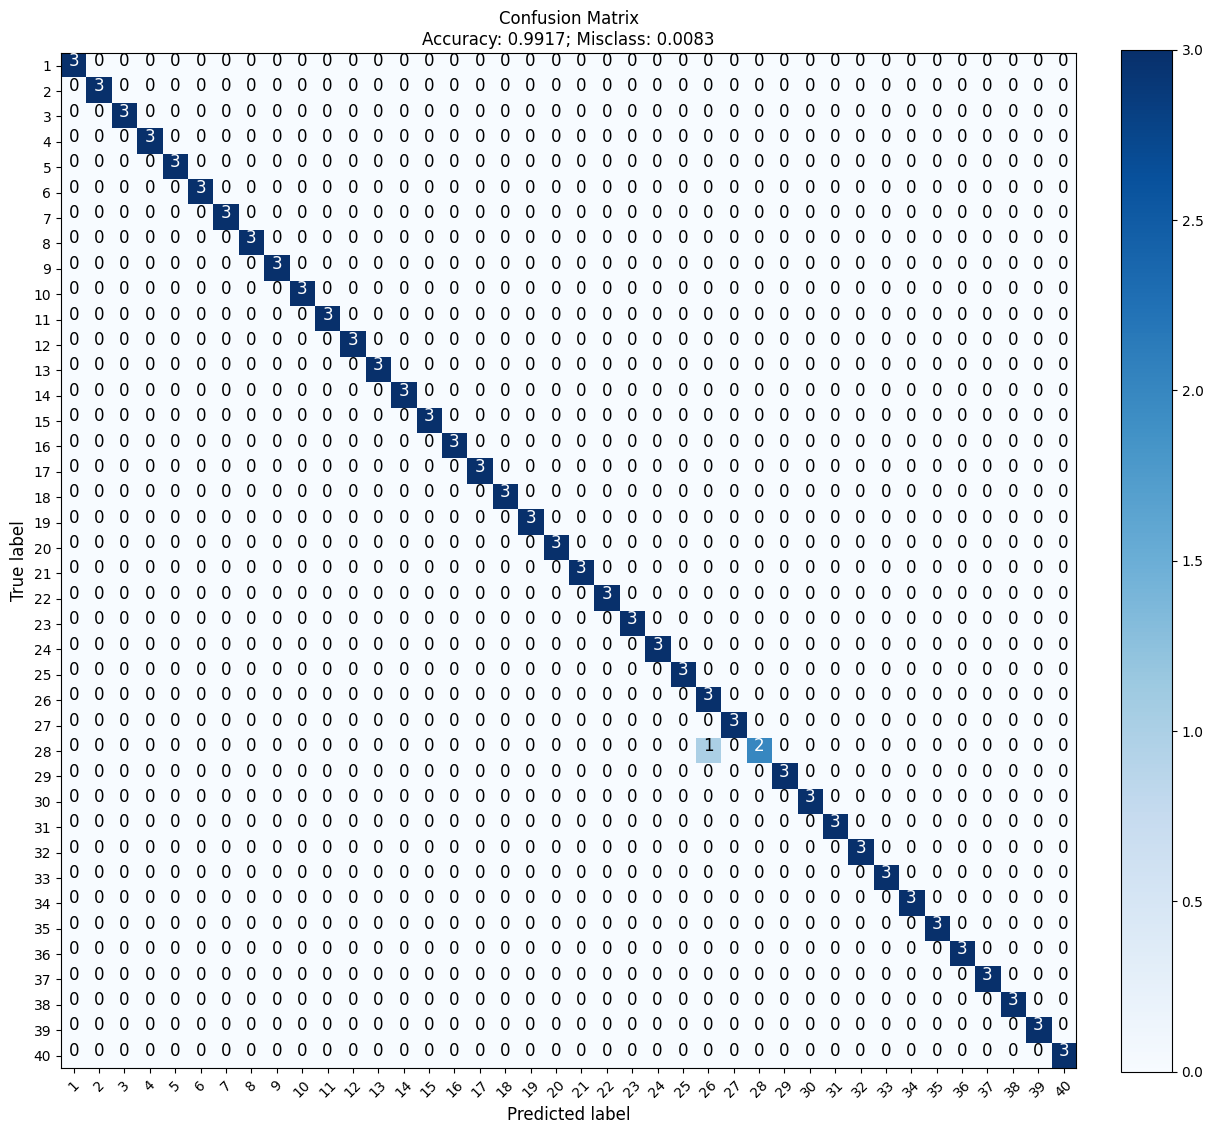

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
mat = confusion_matrix(y_test_shuffled, y_pred)

plot_confusion_matrix(cm=mat,
                      target_names = [i for i in range(1, 40+1)])


In [ ]:
accuracy = accuracy_score(y_test_shuffled, y_pred)
report = classification_report(y_test_shuffled, y_pred)
print("Classification Report: \n", report)

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3
          16       1.00      1.00      1.00         3
  

99.16666666666667


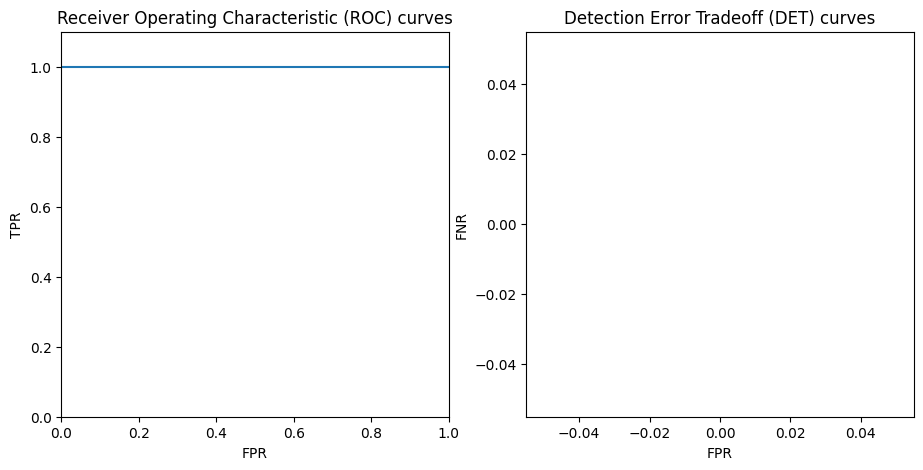

In [ ]:
# probability matrix NxM where N is number of samples and M is the number of classes
probability_matrix = mlp.predict_proba(X_test_shuffled)

# calculate accuracy
prediction = np.argmax(probability_matrix,1)
result = prediction == y_test_shuffled
accuracy = (np.sum(result)/len(result))*100
print(accuracy)

# false positive rate (FPR)
# true positive rate (TPR)
# false negative rate (FNR)
# 40 subjects by 100 values
roc_fpr = np.zeros((40,100))
roc_tpr = np.zeros((40,100))
det_fpr = np.zeros((40,100))
det_fnr = np.zeros((40,100))
fig , [ax_roc , ax_det] = plt.subplots(1,2,figsize=(11,5))

# iterate through number of subjects (40)
# calculating the ROC and DET curve for each subject
for i in range (40):
# find the fpr by tpr values for ROC
  fpr,tpr, _ = roc_curve(y_test_shuffled[:]==i, probability_matrix[:,i])
  # interpolate rates so each curve contains 100 values
  roc_fpr[i] = np.linspace(min(fpr),max(fpr),100)
  roc_tpr[i] = np.interp(roc_fpr[i],fpr,tpr)
  # find the fpr by fnr values for DET
  fpr,fnr, _ = det_curve(y_test_shuffled[:]==i, probability_matrix[:,i])
  # interpolate rates so each curve contains 100 values
  det_fpr[i] = np.linspace(min(fpr),max(fpr),100)
  det_fnr[i] = np.interp(det_fpr[i],fpr,fnr)

# average each subject ’s ROC curve to get the average ROC curve of system
roc_mid_fpr = np.mean(roc_fpr,0)
roc_mid_tpr = np.mean(roc_tpr,0)
ax_roc.plot(roc_mid_fpr, roc_mid_tpr)
# average each subject ’s DET curve to get the average DET curve of system
det_mid_fpr = np.mean(det_fpr,0)
det_mid_fnr = np.mean(det_fnr,0)
ax_det.plot(det_mid_fpr, det_mid_fnr)
# ax_det.plot(roc_mid_fpr, roc_mid_tpr)
ax_roc.set_xlabel('FPR')
ax_roc.set_ylabel('TPR')
ax_roc.set_ylim([0,1.1])
ax_roc.set_xlim([0,1])
ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_xlabel('FPR')
ax_det.set_ylabel('FNR')
# ax_det.set_xlim([0,1])
# ax_det.set_ylim([0,1.1])
ax_det.set_title("Detection Error Tradeoff (DET) curves")
plt.show()

In [ ]:
y_pred = mlp.predict(X_test_shuffled)
prediction_evaluation(y_pred,y_test_shuffled)

Overall Accuracy: 99%
Subject #1:
	TP: 3, FP: 0, TN: 117, FN: 0
	TPR: 100.00%, TNR: 100.00%, FPR: 0.00%, FNR: 0.00%


## Using Predict()

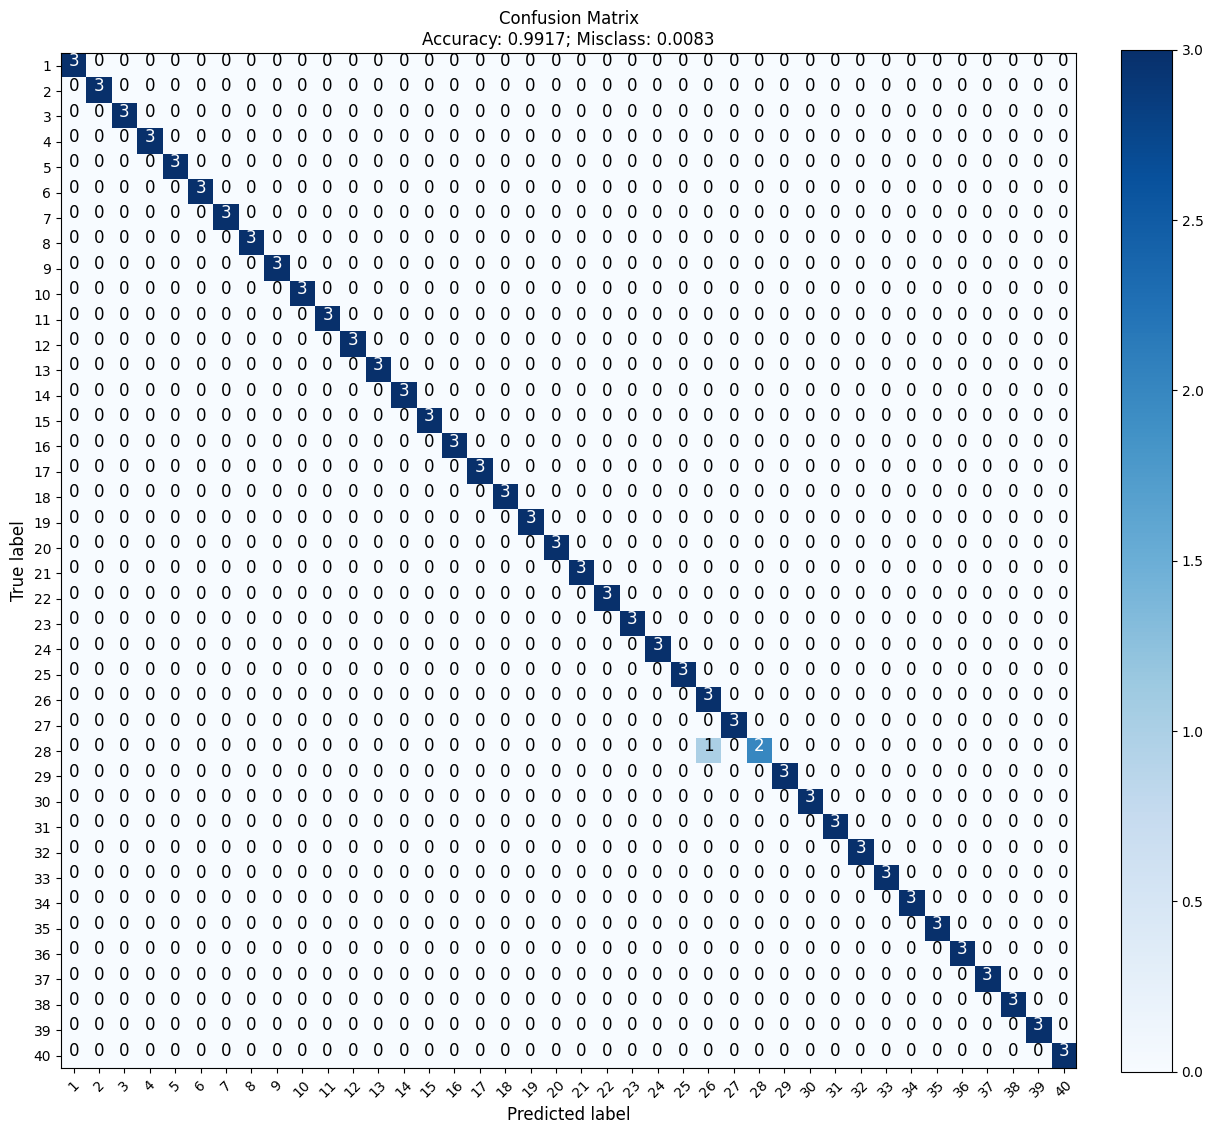

In [ ]:
y_pred = mlp.predict(X_test_shuffled)
confusionMatrix = confusion_matrix(y_test_shuffled, y_pred)
plot_confusion_matrix(cm=confusionMatrix,
                      target_names = [i for i in range(1, 40+1)])